## TrainingRunnner

- setup dataloader
- start training

## Import and Setup

In [1]:
# ! pip install -r requirements.txt

In [2]:
%load_ext autoreload
%autoreload 2|

In [3]:
#export 
from exp.nb_CustomDataLoader import Detection_dataset

In [4]:
import os, sys
base = "/Users/ckh/Documents/Poladrone/nb"
# base = "D:/YoloV5_Hui/poladrone_nb/ref/pytorchYOLOv4
sys.path.append(base + "/ref/pytorchYOLOv4")

In [5]:
from ref.pytorchYOLOv4.train import *
import torch.nn as nn

## Function

In [6]:
def custom_collate(batch):
    images = []
    bboxes = []
    for i, (img, box) in enumerate(batch):
        images.append([img])
        
        box = np.concatenate((box, [[i]]*len(box)), 1)
        bboxes.append(box)
        
    images = np.concatenate(images, axis=0)
    images = images.transpose(0, 3, 1, 2)
    images = torch.from_numpy(images).div(255.0)
            
    bboxes = np.concatenate(bboxes)

    bboxes = torch.from_numpy(bboxes)
    return images, bboxes

In [7]:
class Custom_Yolo_loss(nn.Module):
    def __init__(self, n_classes=80, n_anchors=3, device=None, batch=2):
        super(Custom_Yolo_loss, self).__init__()
        self.device = device
        self.strides = [8, 16, 32]
        image_size = 416
        self.n_classes = n_classes
        self.n_anchors = n_anchors

        self.anchors = [[12, 16], [19, 36], [40, 28], [36, 75], [76, 55], [72, 146], [142, 110], [192, 243], [459, 401]]
        self.anch_masks = [[0, 1, 2], [3, 4, 5], [6, 7, 8]]
        self.ignore_thre = 0.5

        self.masked_anchors, self.ref_anchors, self.grid_x, self.grid_y, self.anchor_w, self.anchor_h = [], [], [], [], [], []

        for i in range(3):
            all_anchors_grid = [(w / self.strides[i], h / self.strides[i]) for w, h in self.anchors]
            masked_anchors = np.array([all_anchors_grid[j] for j in self.anch_masks[i]], dtype=np.float32)
            ref_anchors = np.zeros((len(all_anchors_grid), 4), dtype=np.float32)
            ref_anchors[:, 2:] = np.array(all_anchors_grid, dtype=np.float32)
            ref_anchors = torch.from_numpy(ref_anchors)
            # calculate pred - xywh obj cls
            fsize = image_size // self.strides[i]
            grid_x = torch.arange(fsize, dtype=torch.float).repeat(batch, 3, fsize, 1).to(device)
            grid_y = torch.arange(fsize, dtype=torch.float).repeat(batch, 3, fsize, 1).permute(0, 1, 3, 2).to(device)
            anchor_w = torch.from_numpy(masked_anchors[:, 0]).repeat(batch, fsize, fsize, 1).permute(0, 3, 1, 2).to(
                device)
            anchor_h = torch.from_numpy(masked_anchors[:, 1]).repeat(batch, fsize, fsize, 1).permute(0, 3, 1, 2).to(
                device)
            
            self.masked_anchors.append(masked_anchors)
            self.ref_anchors.append(ref_anchors)
            self.grid_x.append(grid_x)
            self.grid_y.append(grid_y)
            self.anchor_w.append(anchor_w)
            self.anchor_h.append(anchor_h)

    def build_target(self, pred, labels, batchsize, fsize, n_ch, output_id):

        # target assignment
        tgt_mask = torch.zeros(batchsize, self.n_anchors, fsize, fsize, 4 + self.n_classes).to(device=self.device)
        obj_mask = torch.ones(batchsize, self.n_anchors, fsize, fsize).to(device=self.device)
        tgt_scale = torch.zeros(batchsize, self.n_anchors, fsize, fsize, 2).to(self.device)
        target = torch.zeros(batchsize, self.n_anchors, fsize, fsize, n_ch).to(self.device)

        set_trace()
            # labels = labels.cpu().data
        # nlabel = (labels.sum(dim=2) > 0).sum(dim=1)  # number of objects

        # batches_labels =  labels[:,-1]
        # nlabel = [(batches_labels == i).sum() for i in range(batchsize)]

        truth_x_all = (labels[:, 2] + labels[:, 0]) / (self.strides[output_id] * 2)
        truth_y_all = (labels[:, 3] + labels[:, 1]) / (self.strides[output_id] * 2)
        truth_w_all = (labels[:, 2] - labels[:, 0]) / self.strides[output_id]
        truth_h_all = (labels[:, 3] - labels[:, 1]) / self.strides[output_id]
        truth_i_all = truth_x_all.to(torch.int16).cpu().numpy()
        truth_j_all = truth_y_all.to(torch.int16).cpu().numpy()

        set_trace()
        
        for b in range(batchsize):

            img_index = (labels[:,-1] == b)
            n = int(img_index.sum())
            if n == 0:
                continue

            truth_box = torch.zeros(n, 4).to(self.device)
            truth_box[:, 2] = truth_w_all[img_index]
            truth_box[:, 3] = truth_h_all[img_index]
            truth_i = truth_i_all[img_index]
            truth_j = truth_j_all[img_index]

            # calculate iou between truth and reference anchors
            anchor_ious_all = bboxes_iou(truth_box.cpu(), self.ref_anchors[output_id])
            best_n_all = anchor_ious_all.argmax(dim=1)
            best_n = best_n_all % 3
            best_n_mask = ((best_n_all == self.anch_masks[output_id][0]) |
                           (best_n_all == self.anch_masks[output_id][1]) |
                           (best_n_all == self.anch_masks[output_id][2]))

            set_trace()
            
            if sum(best_n_mask) == 0:
                continue

            truth_box[:, 0] = truth_x_all[img_index]
            truth_box[:, 1] = truth_y_all[img_index]

            pred_ious = bboxes_iou(pred[b].view(-1, 4), truth_box, xyxy=False)
            pred_best_iou, _ = pred_ious.max(dim=1)
            pred_best_iou = (pred_best_iou > self.ignore_thre)
            pred_best_iou = pred_best_iou.view(pred[b].shape[:3])
            # set mask to zero (ignore) if pred matches truth
            obj_mask[b] = ~ pred_best_iou

            for ti in range(best_n.shape[0]):
                if best_n_mask[ti] == 1:
                    i, j = truth_i[ti], truth_j[ti]
                    a = best_n[ti]
                    obj_mask[b, a, j, i] = 1
                    tgt_mask[b, a, j, i, :] = 1
                    target[b, a, j, i, 0] = truth_x_all[ti] - truth_x_all[ti].to(torch.int16).to(torch.float)
                    target[b, a, j, i, 1] = truth_y_all[ti] - truth_y_all[ti].to(torch.int16).to(torch.float)
                    target[b, a, j, i, 2] = torch.log(
                        truth_w_all[ti] / torch.Tensor(self.masked_anchors[output_id])[best_n[ti], 0] + 1e-16)
                    target[b, a, j, i, 3] = torch.log(
                        truth_h_all[ti] / torch.Tensor(self.masked_anchors[output_id])[best_n[ti], 1] + 1e-16)
                    target[b, a, j, i, 4] = 1
                    target[b, a, j, i, 5 + labels[ti, 4].to(torch.int16).cpu().numpy()] = 1
                    tgt_scale[b, a, j, i, :] = torch.sqrt(2 - truth_w_all[ti] * truth_h_all[ti] / fsize / fsize)

        set_trace()
        
        return obj_mask, tgt_mask, tgt_scale, target

    def forward(self, xin, labels=None):
        loss, loss_xy, loss_wh, loss_obj, loss_cls, loss_l2 = 0, 0, 0, 0, 0, 0
        
        set_trace()
        
        for output_id, output in enumerate(xin):
            
            batchsize = output.shape[0]
            fsize = output.shape[2]

            n_ch = 5 + self.n_classes

            output = output.view(batchsize, self.n_anchors, n_ch, fsize, fsize)
            output = output.permute(0, 1, 3, 4, 2)  # .contiguous()

            # logistic activation for xy, obj, cls
            output[..., np.r_[:2, 4:n_ch]] = torch.sigmoid(output[..., np.r_[:2, 4:n_ch]])

            pred = output[..., :4].clone()
            pred[..., 0] += self.grid_x[output_id]
            pred[..., 1] += self.grid_y[output_id]
            pred[..., 2] = torch.exp(pred[..., 2]) * self.anchor_w[output_id]
            pred[..., 3] = torch.exp(pred[..., 3]) * self.anchor_h[output_id]

            ## get label for this batch only
            set_trace()
            
            obj_mask, tgt_mask, tgt_scale, target = self.build_target(pred, labels, batchsize, fsize, n_ch, output_id)

            # loss calculation
            output[..., 4] *= obj_mask
            output[..., np.r_[0:4, 5:n_ch]] *= tgt_mask
            output[..., 2:4] *= tgt_scale

            target[..., 4] *= obj_mask
            target[..., np.r_[0:4, 5:n_ch]] *= tgt_mask
            target[..., 2:4] *= tgt_scale

            set_trace()
            
            loss_xy += F.binary_cross_entropy(input=output[..., :2], target=target[..., :2],
                                              weight=tgt_scale * tgt_scale, reduction='sum')
            loss_wh += F.mse_loss(input=output[..., 2:4], target=target[..., 2:4], reduction='sum') / 2
            loss_obj += F.binary_cross_entropy(input=output[..., 4], target=target[..., 4], reduction='sum')
            loss_cls += F.binary_cross_entropy(input=output[..., 5:], target=target[..., 5:], reduction='sum')
            loss_l2 += F.mse_loss(input=output, target=target, reduction='sum')

        loss = loss_xy + loss_wh + loss_obj + loss_cls

        return loss, loss_xy, loss_wh, loss_obj, loss_cls, loss_l2

In [8]:
def custom_train(train_dataset, val_dataset, model, device, config, epochs=5, batch_size=1, save_cp=True, log_step=20, img_scale=0.5):
#     train_dataset = Yolo_dataset(config.train_label, config)
#     val_dataset = Yolo_dataset(config.val_label, config)

    n_train = len(train_dataset)
    n_val = len(val_dataset)

    train_loader = DataLoader(train_dataset, batch_size=config.batch // config.subdivisions, shuffle=True,
                              num_workers=4, pin_memory=True, drop_last=True, collate_fn=custom_collate)

    val_loader = DataLoader(val_dataset, batch_size=config.batch // config.subdivisions, shuffle=False, num_workers=1,
                            pin_memory=True, drop_last=True, collate_fn=custom_collate)

    writer = SummaryWriter(log_dir=config.TRAIN_TENSORBOARD_DIR,
                           filename_suffix=f'OPT_{config.TRAIN_OPTIMIZER}_LR_{config.learning_rate}_BS_{config.batch}_Sub_{config.subdivisions}_Size_{config.width}',
                           comment=f'OPT_{config.TRAIN_OPTIMIZER}_LR_{config.learning_rate}_BS_{config.batch}_Sub_{config.subdivisions}_Size_{config.width}')

    max_itr = config.TRAIN_EPOCHS * n_train
    # global_step = cfg.TRAIN_MINEPOCH * n_train
    global_step = 0
    logging.info(f'''Starting training:
        Epochs:          {epochs}
        Batch size:      {config.batch}
        Subdivisions:    {config.subdivisions}
        Learning rate:   {config.learning_rate}
        Training size:   {n_train}
        Validation size: {n_val}
        Checkpoints:     {save_cp}
        Device:          {device.type}
        Images size:     {config.width}
        Optimizer:       {config.TRAIN_OPTIMIZER}
        Dataset classes: {config.classes}
        Train label path:{config.train_label}
        Pretrained:
    ''')

    # learning rate setup
    def burnin_schedule(i):
        if i < config.burn_in:
            factor = pow(i / config.burn_in, 4)
        elif i < config.steps[0]:
            factor = 1.0
        elif i < config.steps[1]:
            factor = 0.1
        else:
            factor = 0.01
        return factor

    optimizer = optim.Adam(model.parameters(), lr=config.learning_rate / config.batch, betas=(0.9, 0.999), eps=1e-08)
    scheduler = optim.lr_scheduler.LambdaLR(optimizer, burnin_schedule)

    criterion = Custom_Yolo_loss(n_classes=config.classes, device=device, batch=config.batch // config.subdivisions)
    
    # scheduler = ReduceLROnPlateau(optimizer, mode='max', verbose=True, patience=6, min_lr=1e-7)
    # scheduler = CosineAnnealingWarmRestarts(optimizer, 0.001, 1e-6, 20)


    for epoch in range(epochs):
        #model.train()
        epoch_loss = 0
        epoch_step = 0

        model.train()
        with tqdm(total=n_train, desc=f'Epoch {epoch + 1}/{epochs}', unit='img', ncols=50) as pbar:
            for i, batch in enumerate(train_loader):
                global_step += 1
                epoch_step += 1
                images = batch[0]
                bboxes = batch[1]

                images = images.to(device=device, dtype=torch.float32)
                bboxes = bboxes.to(device=device)
                
                bboxes_pred = model(images)
                loss, loss_xy, loss_wh, loss_obj, loss_cls, loss_l2 = criterion(bboxes_pred, bboxes)
                # loss = loss / config.subdivisions
                loss.backward()

                epoch_loss += loss.item()

                if global_step  % config.subdivisions == 0:
                    optimizer.step()
                    scheduler.step()
                    model.zero_grad()

                if global_step % (log_step * config.subdivisions) == 0:
                    writer.add_scalar('train/Loss', loss.item(), global_step)
                    writer.add_scalar('train/loss_xy', loss_xy.item(), global_step)
                    writer.add_scalar('train/loss_wh', loss_wh.item(), global_step)
                    writer.add_scalar('train/loss_obj', loss_obj.item(), global_step)
                    writer.add_scalar('train/loss_cls', loss_cls.item(), global_step)
                    writer.add_scalar('train/loss_l2', loss_l2.item(), global_step)
                    writer.add_scalar('lr', scheduler.get_last_lr()[0]* config.batch, global_step)
                    
                    pbar.set_postfix(**{'loss (batch)': loss.item(), 
                                        'loss_xy': loss_xy.item(),
                                        'loss_wh': loss_wh.item(),
                                        'loss_obj': loss_obj.item(),
                                        'loss_cls': loss_cls.item(),
                                        'loss_l2': loss_l2.item(),
                                        'lr': scheduler.get_lr()[0] * config.batch
                                        })
                    
                    logging.debug('Train step_{}: loss : {},loss xy : {},loss wh : {},'
                                  'loss obj : {}，loss cls : {},loss l2 : {},lr : {}'
                                  .format(global_step, loss.item(), loss_xy.item(),
                                          loss_wh.item(), loss_obj.item(),
                                          loss_cls.item(), loss_l2.item(),
                                          scheduler.get_last_lr()[0] * config.batch))

                pbar.update(images.shape[0])
                
                break
                
        continue
        model.eval()
        with tqdm(total=n_val, desc=f'Val: Epoch {epoch + 1}', unit='img', ncols=50) as pbar:
            val_loss = 0
            for j, batch in enumerate(val_loader):      
                images = batch[0]
                bboxes = batch[1]

                images = images.to(device=device, dtype=torch.float32)
                bboxes = bboxes.to(device=device)

                bboxes_pred = model(images)
                loss, loss_xy, loss_wh, loss_obj, loss_cls, loss_l2 = criterion(bboxes_pred, bboxes)

                val_loss += loss.item()

                pbar.update(images.shape[0])
                pbar.set_postfix_str("Loss:%f.2"%(val_loss))
                
                if j==3:
                    break
                    
            writer.add_scalar('val/Loss', val_loss.item(), global_step)
                
            if save_cp:
                try:
                    os.mkdir(config.checkpoints)
                    logging.info('Created checkpoint directory')
                except OSError:
                    pass
                torch.save(model.state_dict(), os.path.join(config.checkpoints, f'Yolov4_epoch{epoch + 1}.pth'))
                logging.info(f'Checkpoint {epoch + 1} saved !')

    writer.close()

## Main

### Build DataLoader

In [9]:
from config.config import Cfg

data_list = "/Users/ckh/OneDrive - Default Directory/Hui_Wan/train_npt.txt"
# data_list = "D:/YoloV5_Hui/Hui_Wan/train_npt.txt

dataset = Detection_dataset(data_list, Cfg)
dataset.names

## without augmentation
val_dataset = Detection_dataset(data_list, Cfg, val=True)

### Config

In [10]:
logging = init_logger(log_dir='log', stdout=False)

log file path:log/log_2020-07-09_15-38-55.txt


In [11]:
cfg = get_args(**Cfg)
cfg.classes = 1 ## hardcode num_classes

os.environ["CUDA_VISIBLE_DEVICES"] = cfg.gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logging.info(f'Using device {device}')

print("Device:", device)

Device: cpu


### Train

In [12]:
model = Yolov4(cfg.pretrained,n_classes=cfg.classes)

if torch.cuda.device_count() > 1:
    model = torch.nn.DataParallel(model)
model.to(device=device)

print("Training Config: ")
cfg

Training Config: 


{'batch': 2,
 'subdivisions': 2,
 'width': 416,
 'height': 416,
 'channels': 3,
 'momentum': 0.949,
 'decay': 0.0005,
 'angle': 0,
 'saturation': 1.1,
 'exposure': 1.1,
 'hue': 0.1,
 'learning_rate': 0.001,
 'burn_in': 1000,
 'max_batches': 500500,
 'steps': [400000, 450000],
 'policy': [400000, 450000],
 'scales': [0.1, 0.1],
 'cutmix': 0,
 'mosaic': 1,
 'letter_box': 0,
 'jitter': 0.2,
 'classes': 1,
 'track': 0,
 'w': 416,
 'h': 416,
 'flip': 1,
 'blur': 0,
 'gaussian': 0,
 'boxes': 60,
 'TRAIN_EPOCHS': 300,
 'train_label': 'train.txt',
 'val_label': 'data/val.txt',
 'TRAIN_OPTIMIZER': 'adam',
 'mixup': 3,
 'checkpoints': 'checkpoints',
 'TRAIN_TENSORBOARD_DIR': 'log',
 'load': '/Users/ckh/Library/Jupyter/runtime/kernel-4a14719f-7c89-4c48-9f9c-29704ec3b019.json',
 'gpu': '-1',
 'dataset_dir': None,
 'pretrained': None}

In [ ]:
import random
import torch
torch.manual_seed(20)
np.random.seed(20)
random.seed(20)


try:
    custom_train(
        train_dataset=dataset,
        val_dataset=val_dataset,
        model=model,
        config=cfg,
        epochs=cfg.TRAIN_EPOCHS,
        device=device,
        log_step=1000)
except KeyboardInterrupt:
    torch.save(model.state_dict(), 'INTERRUPTED.pth')
    logging.info('Saved interrupt')
    try:
        sys.exit(0)
    except SystemExit:
        os._exit(0)

Epoch 1/300:   0%|       | 0/121 [00:00<?, ?img/s]

> <ipython-input-7-6672b0ac5789>(123)forward()
    121         set_trace()
    122 
--> 123         for output_id, output in enumerate(xin):
    124 
    125             batchsize = output.shape[0]

ipdb> xin
[tensor([[[[ 3.5556e-01,  3.8027e-01,  4.0256e-01,  ...,  3.4650e-01,
            3.2504e-01,  3.8034e-01],
          [ 2.0487e-01,  2.6513e-01,  3.1430e-01,  ...,  4.1501e-01,
            3.5605e-01,  3.5909e-01],
          [ 2.9648e-01,  5.2146e-02,  3.8356e-01,  ...,  5.1282e-01,
            4.7947e-01, -4.7787e-02],
          ...,
          [ 3.1688e-01,  6.6996e-01,  5.4726e-03,  ...,  4.4695e-01,
            8.4266e-01,  3.3139e-01],
          [ 6.5251e-01,  8.8600e-01,  4.6293e-01,  ...,  4.8167e-01,
            8.6577e-01,  4.7851e-01],
          [ 7.1027e-01,  7.9489e-01,  5.4970e-01,  ...,  9.5081e-01,
            5.6268e-01,  3.5644e-01]],

         [[ 1.2951e-01,  4.5665e-01,  3.9675e-01,  ...,  1.0989e-01,
            2.7292e-01,  1.4814e-01],
          [ 2.4767e-01, 

ipdb> xin.shape
*** AttributeError: 'list' object has no attribute 'shape'
ipdb> len(xin)
3
ipdb> xin[0].shape
torch.Size([1, 18, 52, 52])
ipdb> c
> <ipython-input-7-6672b0ac5789>(145)forward()
    143             set_trace()
    144 
--> 145             obj_mask, tgt_mask, tgt_scale, target = self.build_target(pred, labels, batchsize, fsize, n_ch, output_id)
    146 
    147             # loss calculation

ipdb> output.shape
torch.Size([1, 3, 52, 52, 6])
ipdb> tgt_mask.shape
*** NameError: name 'tgt_mask' is not defined
ipdb> pred
tensor([[[[[ 0.5880,  0.5323,  1.2991,  2.1404],
           [ 1.5939,  0.6122,  1.0890,  2.2908],
           [ 2.5993,  0.5979,  1.2243,  1.9751],
           ...,
           [49.5858,  0.5274,  1.1382,  2.2022],
           [50.5806,  0.5678,  0.8036,  2.4334],
           [51.5940,  0.5370,  0.9604,  2.1398]],

          [[ 0.5510,  1.5616,  1.2764,  1.8834],
           [ 1.5659,  1.5419,  1.0840,  2.0620],
           [ 2.5779,  1.5786,  1.1391,  1.3068],
   

ipdb> tgt_mask
tensor([[[[[0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0.],
           ...,
           [0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0.]],

          [[0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0.],
           ...,
           [0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0.]],

          [[0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0.],
           ...,
           [0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0.]],

          ...,

          [[0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0.],
           ...,
           [0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0.]],

          [[0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0.],
      

In [ ]:
import random
import torch
torch.manual_seed(20)
np.random.seed(20)
random.seed(20)

[len(dataset[i][1]) for i in range(5)]

## VisualizeResult

In [14]:
model_path = "./weight/Yolov4_epoch327.pth"
image_path = "/Users/ckh/OneDrive - Default Directory/Hui_Wan/Sample_Anno_Data_NPT/18_GSKE_Sungai_Pin_4_ytl_0114.JPG"

## load model
model = Yolov4(cfg.pretrained,n_classes=cfg.classes, inference=True)
model = torch.nn.DataParallel(model)
model.load_state_dict(torch.load(model_path, map_location="cpu"))

<All keys matched successfully>

In [81]:
import cv2

## load image
# img = cv2.imread(image_path)
# img = cv2.resize(img, (416, 416), cv2.INTER_LINEAR)

img_raw = val_dataset[80][0]
img = cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB)
img = img.transpose(2, 0, 1)
img = torch.from_numpy(img).div(255.0)
img = img.unsqueeze(0)

In [82]:
## predict 
out = model(img)


## result 
## convert result
## visulize and plotting

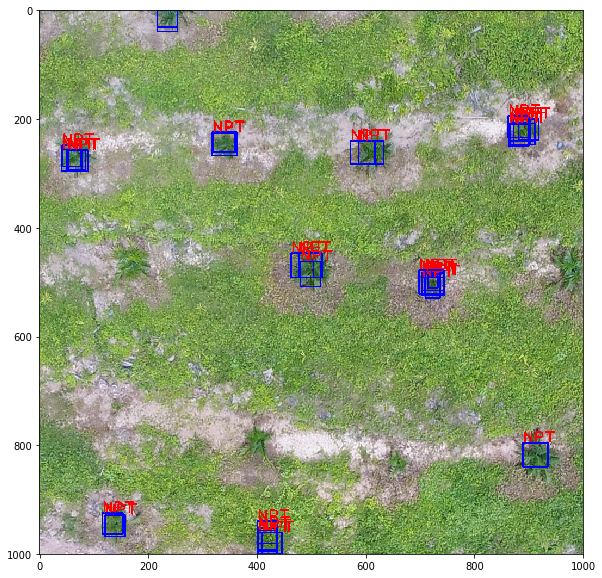

In [83]:
from matplotlib import pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (15, 10)

out_box = out[out[:,:,4] > 0.1]
bboxes = out_box[:,0:4] * 1000
x,y,w,h = bboxes[:,0], bboxes[:,1], bboxes[:,2]/2, bboxes[:,3]/2
                                                            
x1, x2, y1, y2 = x-w, x+w, y-h, y+h

img = img_raw.copy()
border = 2
font_size = 2
for b in zip(x1,y1,x2,y2):
    b = list(map(int,b))
#     print(b)
    cv2.rectangle(img, (b[0],b[1]), (b[2],b[3]), (0,0,255), border)
    text = "NPT" ##self.id_names[b[4]]
    cv2.putText(img, text, (b[0],b[1]), cv2.FONT_HERSHEY_PLAIN, font_size, (255,0,0), border)
    
plt.imshow(img)

## Export

In [30]:
%%javascript
var kernel = IPython.notebook.kernel;
var thename = window.document.getElementById("notebook_name").innerHTML;
var command = "NOTEBOOK = " + "'"+thename+"'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [31]:
!python notebook2script.py "$NOTEBOOK".ipynb

Traceback (most recent call last):
  File "notebook2script.py", line 75, in <module>
    if __name__ == '__main__': fire.Fire(notebook2script)
  File "/Users/ckh/anaconda3/lib/python3.6/site-packages/fire/core.py", line 138, in Fire
    component_trace = _Fire(component, args, parsed_flag_args, context, name)
  File "/Users/ckh/anaconda3/lib/python3.6/site-packages/fire/core.py", line 468, in _Fire
    target=component.__name__)
  File "/Users/ckh/anaconda3/lib/python3.6/site-packages/fire/core.py", line 672, in _CallAndUpdateTrace
    component = fn(*varargs, **kwargs)
  File "notebook2script.py", line 46, in notebook2script
    if not allFiles: notebook2scriptSingle(fname)
  File "notebook2script.py", line 57, in notebook2scriptSingle
    main_dic = json.load(open(fname,'r',encoding="utf-8"))
FileNotFoundError: [Errno 2] No such file or directory: '.ipynb'


In [32]:
%%javascripddt
var kernel = IPython.notebook.kernel;
var thename = window.document.getElementById("notebook_name").innerHTML;
var command = "NOTEBOOK = " + "'"+thename+"'";
kernel.execute(command);

!python notebook2script.py "$NOTEBOOK".ipynb

UsageError: Cell magic `%%javascripddt` not found.
